In [ ]:
# from
# class notebook

# Let’s import the libraries:

In [1]:
# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for assembling a Neural Network model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization 


# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for scaling inputs used in the generator and discriminator


# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib 
import matplotlib.pyplot as plt # or data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version


# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

Tensorflow/Keras: 2.10.0
numpy: 1.23.2
sklearn: 1.2.1
OpenCV: 4.7.0
matplotlib: 3.6.3
graphviz: 0.20.1


In [2]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [3]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
main_dir

'/Users/sviatlanamyshkavets/Documents/Courses/DS TM/DS3onl/Sviatlana Myshkavets'

Next, we download, save and ingest Caltech 101 image dataset. We will only use images of bonsai trees (Category = “bonsai”) instead of an entire list of 101 categories. Also, we will set the resolution to (64 x 64) pixels.

In [5]:
# Specify the location of images after you have downloaded them
ImgLocation = main_dir + "/HW32_Myshkavets S.A./images"

# Create a list to store image paths
ImagePaths=[]
for image in list(os.listdir(ImgLocation)):
    if image != '.DS_Store':
        ImagePaths = ImagePaths + [ImgLocation + "/" + image]
        
# Load images and resize to 64 x 64
data_lowres=[]
for img in ImagePaths:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_lowres = cv2.resize(image, (64, 64))
    data_lowres.append(image_lowres)
    
# Convert image data to numpy array and standardize values (divide by 255 since RGB values ranges from 0 to 255)
data_lowres = np.array(data_lowres, dtype="float") / 255.0

# Show data shape
print("Shape of data_lowres: ", data_lowres.shape)

Shape of data_lowres:  (63565, 64, 64, 3)


The above code prints the shape of our data, which is [samples, rows, columns, channels].

Let’s display a few low-res images to see what we will train our models on.

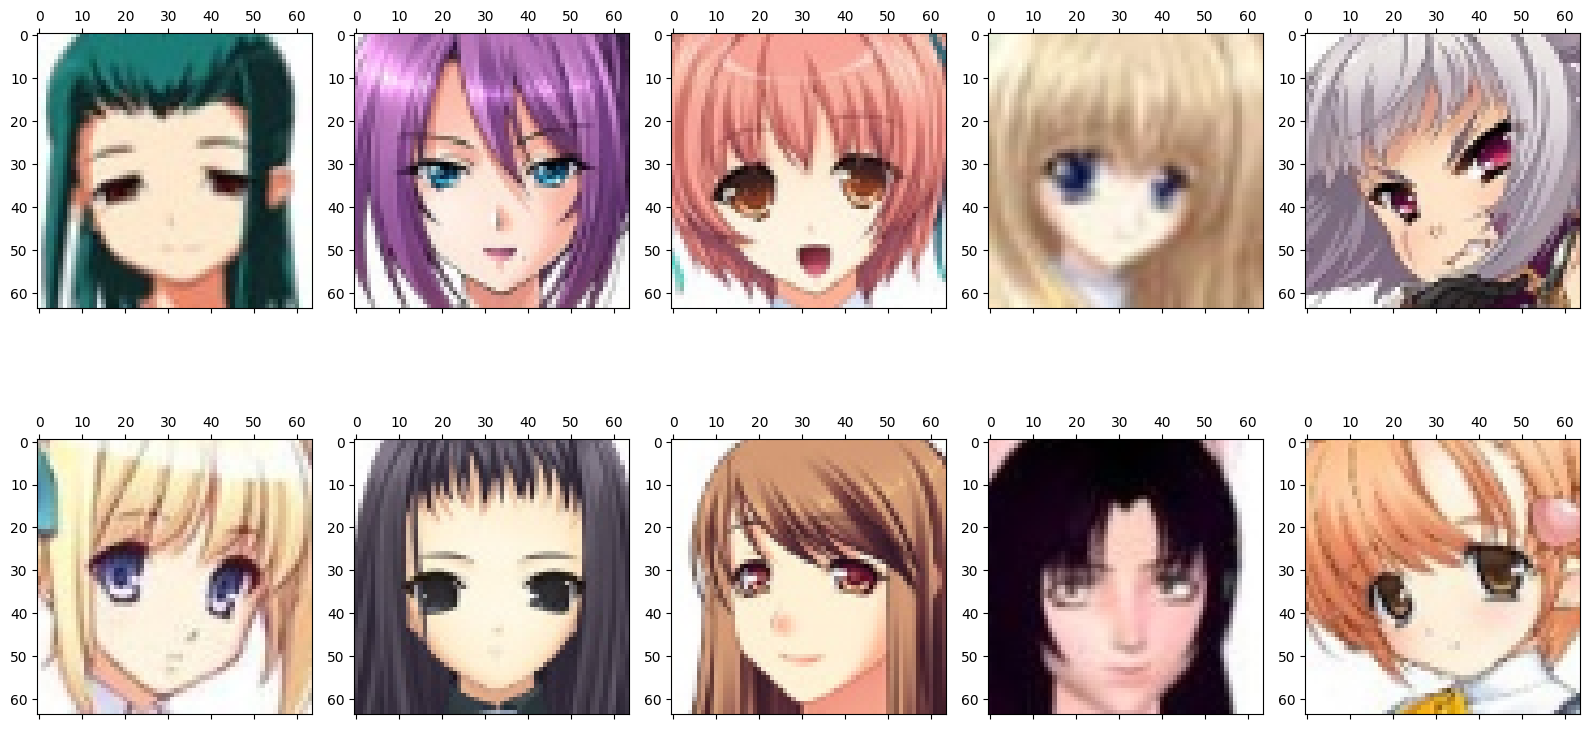

In [6]:
# Display 10 real images
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(data_lowres[n])
        n=n+1
plt.show() 

Finally, let’s scale our image input data which currently has a range of [0,1], to a range of [-1,1]. We do this, so we can use the tanh activation function in the Generator output as it often produces better results.

However, using a sigmoid activation function in the Generator output is also common, which would not require you to rescale images further.

In [7]:
# # Scaler
scaler=MinMaxScaler(feature_range=(-1, 1))

# # Select images that we want to use for model trainng
data=data_lowres.copy()
print("Original shape of the data: ", data.shape)

# # Reshape array
data=data.reshape(-1, 1)
print("Reshaped data: ", data.shape)

# # Fit the scaler
scaler.fit(data)

# # Scale the array
data=scaler.transform(data)

# # Reshape back to the original shape
data=data_lowres.reshape(data_lowres.shape[0], 64, 64, 3)
print("Shape of the scaled array: ", data.shape)

# Creating a GAN model

With data preparation completed, let’s define and assemble our models.

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(64 * 64 * 3, activation="sigmoid"),
    keras.layers.Reshape([64, 64, 3])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[64, 64,3]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

Metal device set to: Apple M1 Pro


2023-04-02 08:28:40.293104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-02 08:28:40.293311: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [10]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(data_lowres).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE) 

In [14]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown 
        for X_batch in dataset:
            X_batch = tf.cast(X_batch, tf.float32)
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
        n=0
        for i in range(0,2):
            for j in range(0,5):
                generated_images = generated_images / 2 + 0.5
                axs[i,j].matshow(generated_images[n])
                n=n+1
        plt.show() 
#         plot_multiple_images(generated_images, 8)                     # not shown
#         plt.show()                   

Epoch 1/50


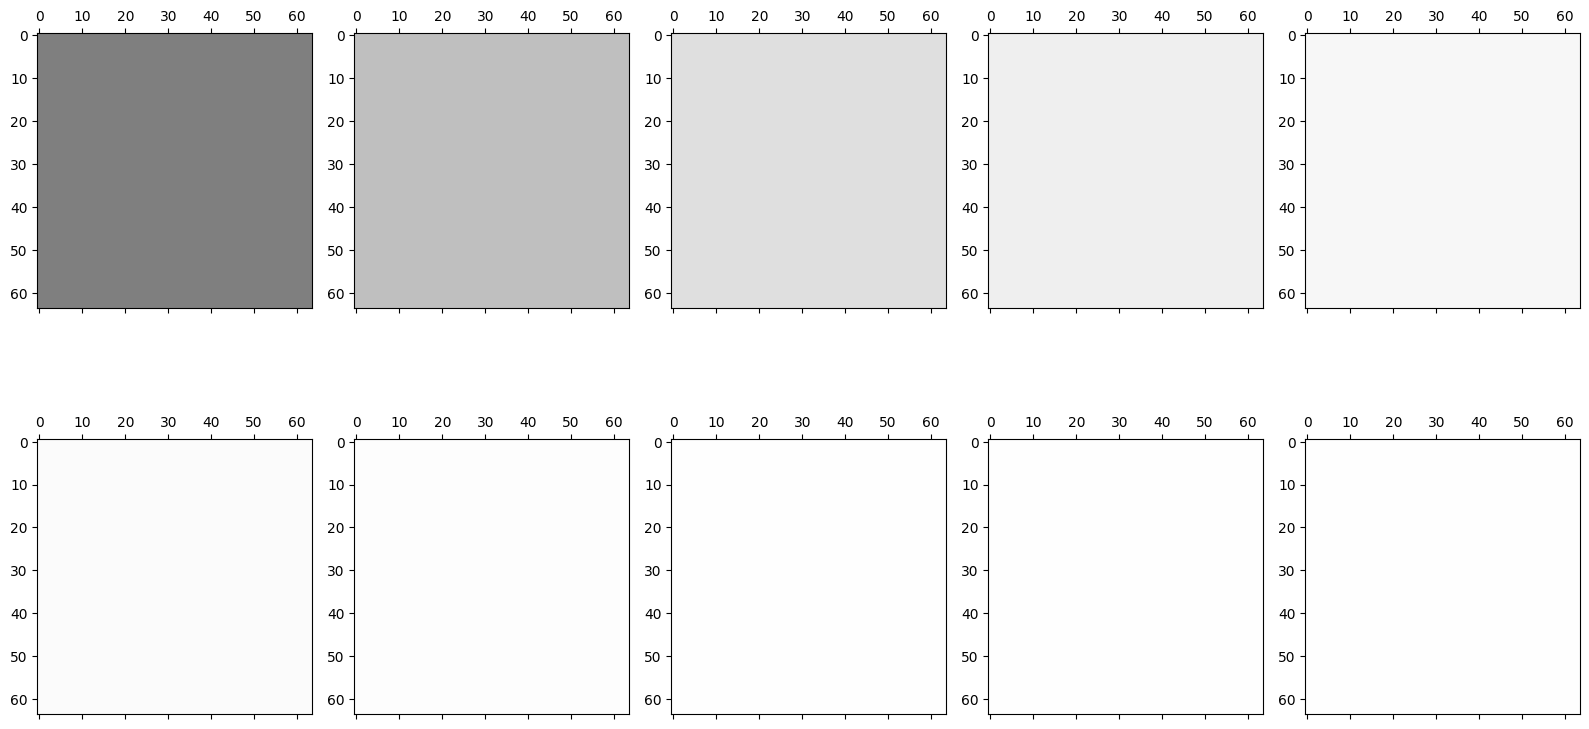

Epoch 2/50


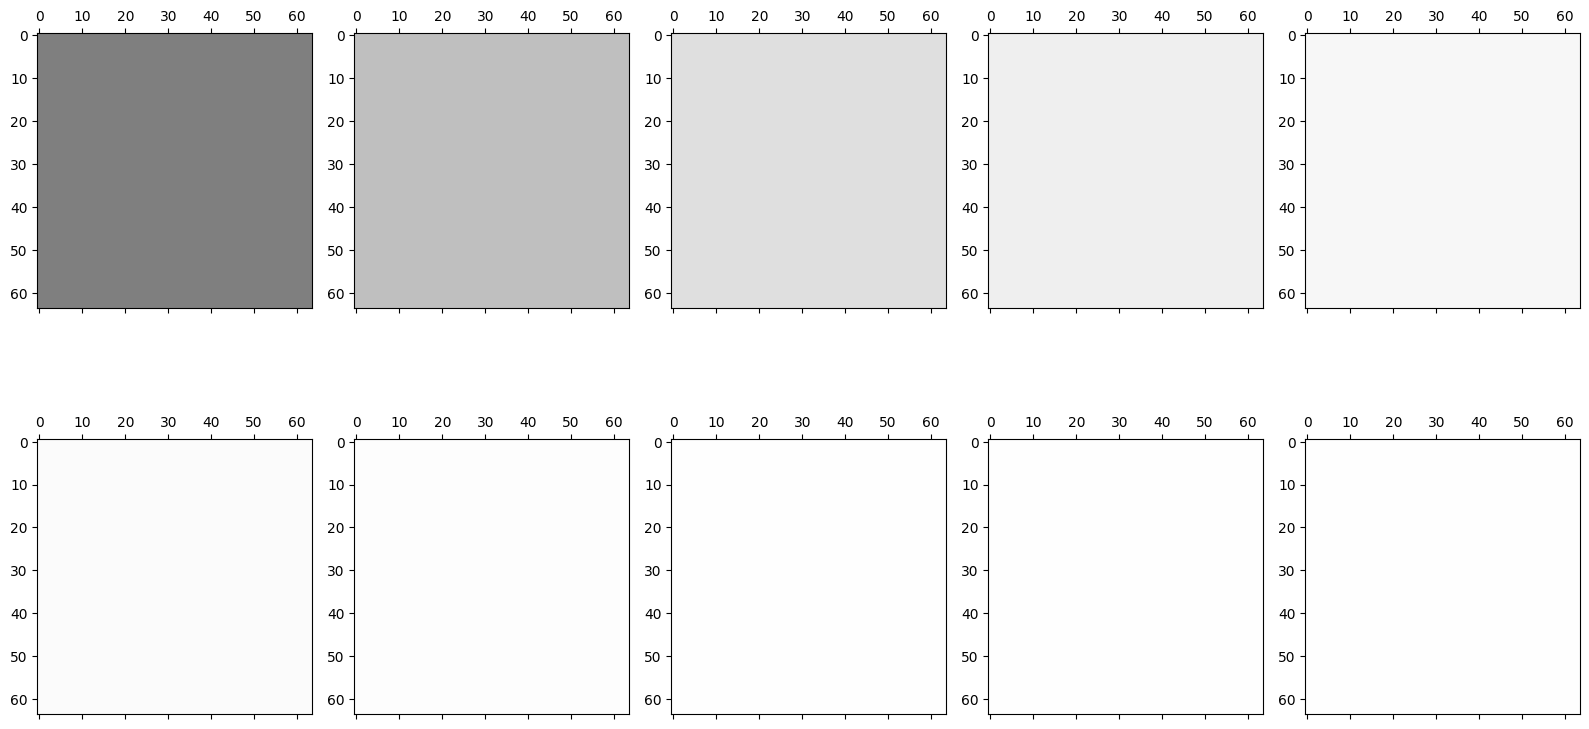

Epoch 3/50


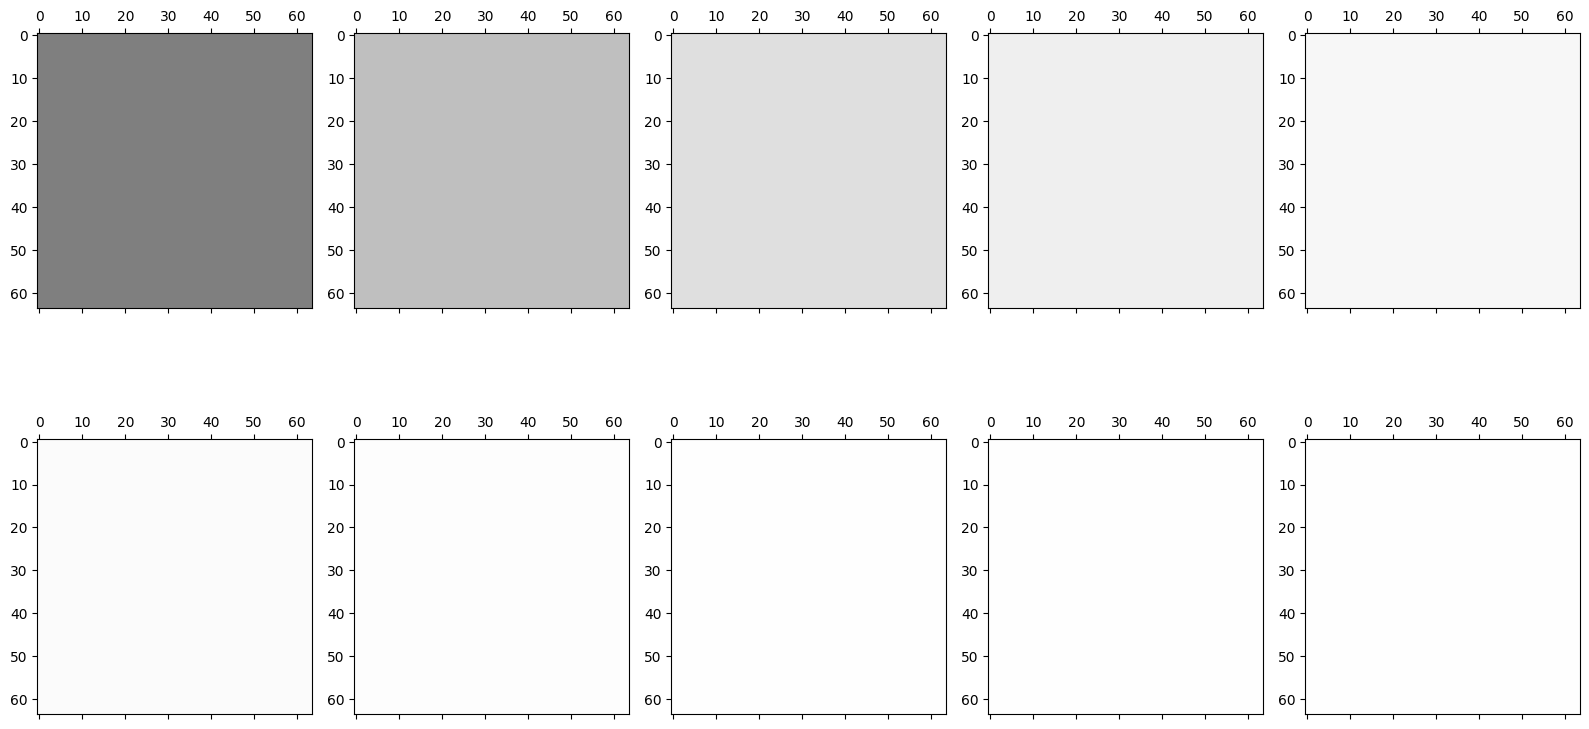

Epoch 4/50


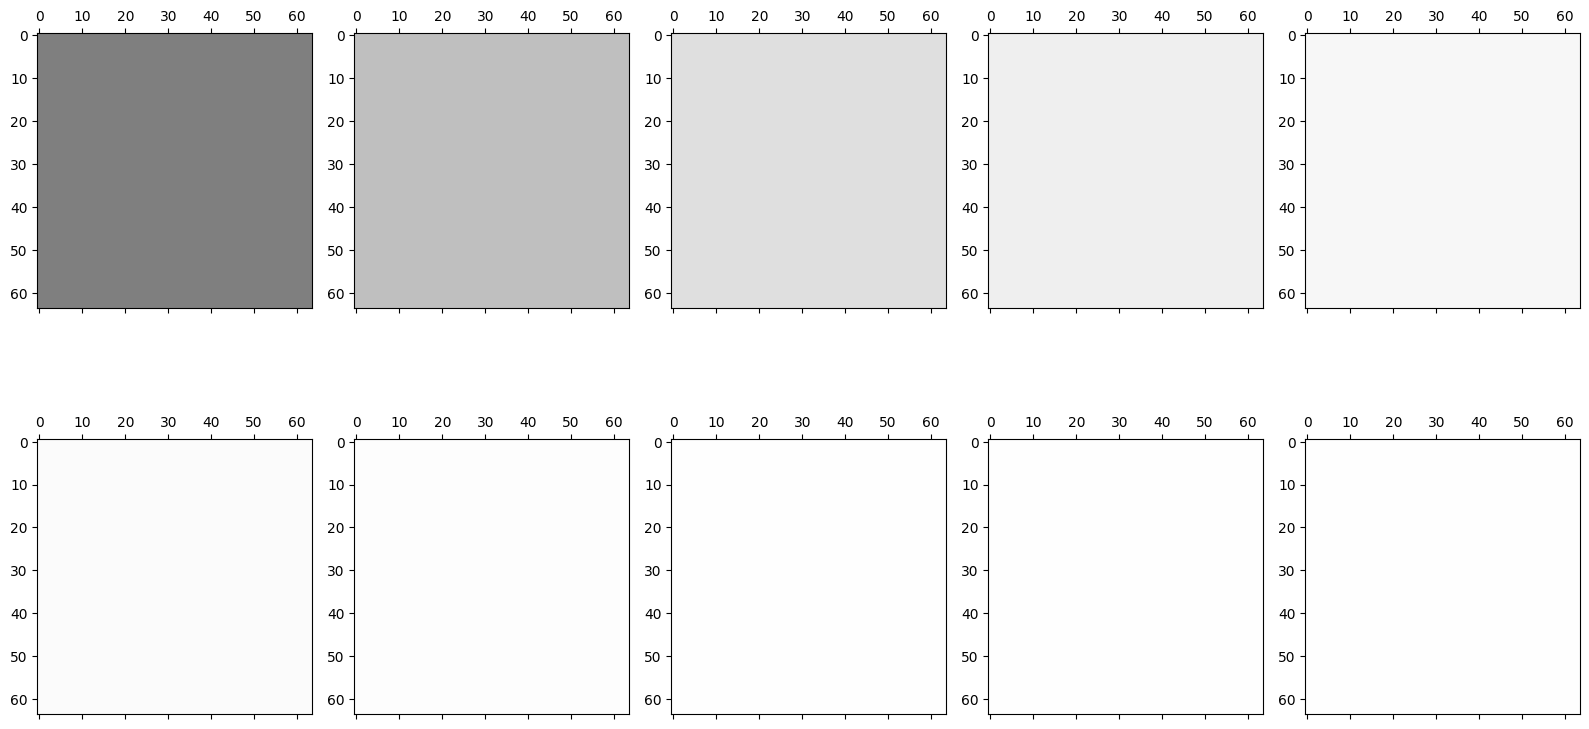

Epoch 5/50


In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

# Creating a DCGAN model

In [8]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([16, 16, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[64, 64, 3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

Metal device set to: Apple M1 Pro


2023-04-02 01:14:27.119281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-02 01:14:27.119483: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                        

In [10]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 32769     
                                                                 
Total params: 242,561
Trainable params: 242,561
Non-tr

In [11]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

# Model training and evaluation

In [12]:
dataset_dcgan = data.reshape(-1, 64, 64, 3) * 2. - 1. # reshape and rescale

In [13]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(dataset_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [14]:
latent_dim = 100 # Our latent space has 100 dimensions. We can change it to any number

In [15]:
def real_samples(n, dataset):
    
    # Samples of real data
    X = dataset[np.random.choice(dataset.shape[0], n, replace=True), :]

    # Class labels
    y = np.ones((n, 1))
    return X, y
    
    
def latent_vector(latent_dim, n):
    
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)
    
    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input
  
    
def fake_samples(generator, latent_dim, n):
    
    # Generate points in latent space
    latent_output = latent_vector(latent_dim, n)
    
    # Predict outputs (i.e., generate fake samples)
    X = generator.predict(latent_output)
    
    # Create class labels
    y = np.zeros((n, 1))
    return X, y   

In [16]:
def performance_summary(generator, discriminator, dataset, latent_dim, n=50):
    
    # Get samples of the real data
    x_real, y_real = real_samples(n, dataset)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)
    
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    # summarize discriminator performance
    print("*** Evaluation ***")
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)
    
    # Display 6 fake images
    x_fake_inv_trans=x_fake.reshape(-1, 1)
    x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
    x_fake_inv_trans=x_fake_inv_trans.reshape(n, 64, 64, 3)
    
    fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,3):
            axs[i,j].matshow(x_fake_inv_trans[k])
            k=k+1
    plt.show() 

In [13]:
def train_gan(gan, dataset, batch_size, codings_size, n_eval=100, n_epochs=1001):
#     half_batch = int(batch_size / 2)
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown 
        for X_batch in dataset:
            X_batch = tf.cast(X_batch, tf.float32)
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
#             print(generated_images.dtype)
#             it floats then the problem is that it's range -1 to 1, and you need to make the range between 0 and 1, and this is how you do it:
#             if 'image.dtype output int then the problem is that values are 0 and 1 and its type is int so convert type to float
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator_loss = discriminator.train_on_batch(X_fake_and_real, y1)
#             discriminator_loss, _ = discriminator.train_on_batch(X_fake_and_real, y1)
            
#             # Prep real samples
#             x_real, y_real = real_samples(half_batch, dataset)
        
#             # Prep fake (generated) samples
#             x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)
        
#             # Train the discriminator using real and fake samples
#             X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
#             discriminator_loss, _ = d_model.train_on_batch(X, y)
            
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
#             gan.train_on_batch(noise, y2)
            generator_loss = gan.train_on_batch(noise, y2)
            
        if (epoch) % n_eval == 0:
            print("Epoch number: ", epoch)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
#             performance_summary(generator, discriminator, dataset, latent_dim)
            fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
            n=0
            for i in range(0,2):
                for j in range(0,5):
                    generated_images = generated_images / 2 + 0.5
#                     generated_images = generated_images * 255
                    axs[i,j].matshow(generated_images[n])
                    n=n+1
            plt.show() 
#         plot_multiple_images(generated_images, 8)                     # not shown
#         plt.show()  

# Results

Epoch 1/1001


2023-04-02 01:15:04.948882: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-02 01:15:04.949235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-02 01:15:05.464314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch number:  0
*** Training ***
Discriminator Loss  0.0
Generator Loss:  26.095226287841797


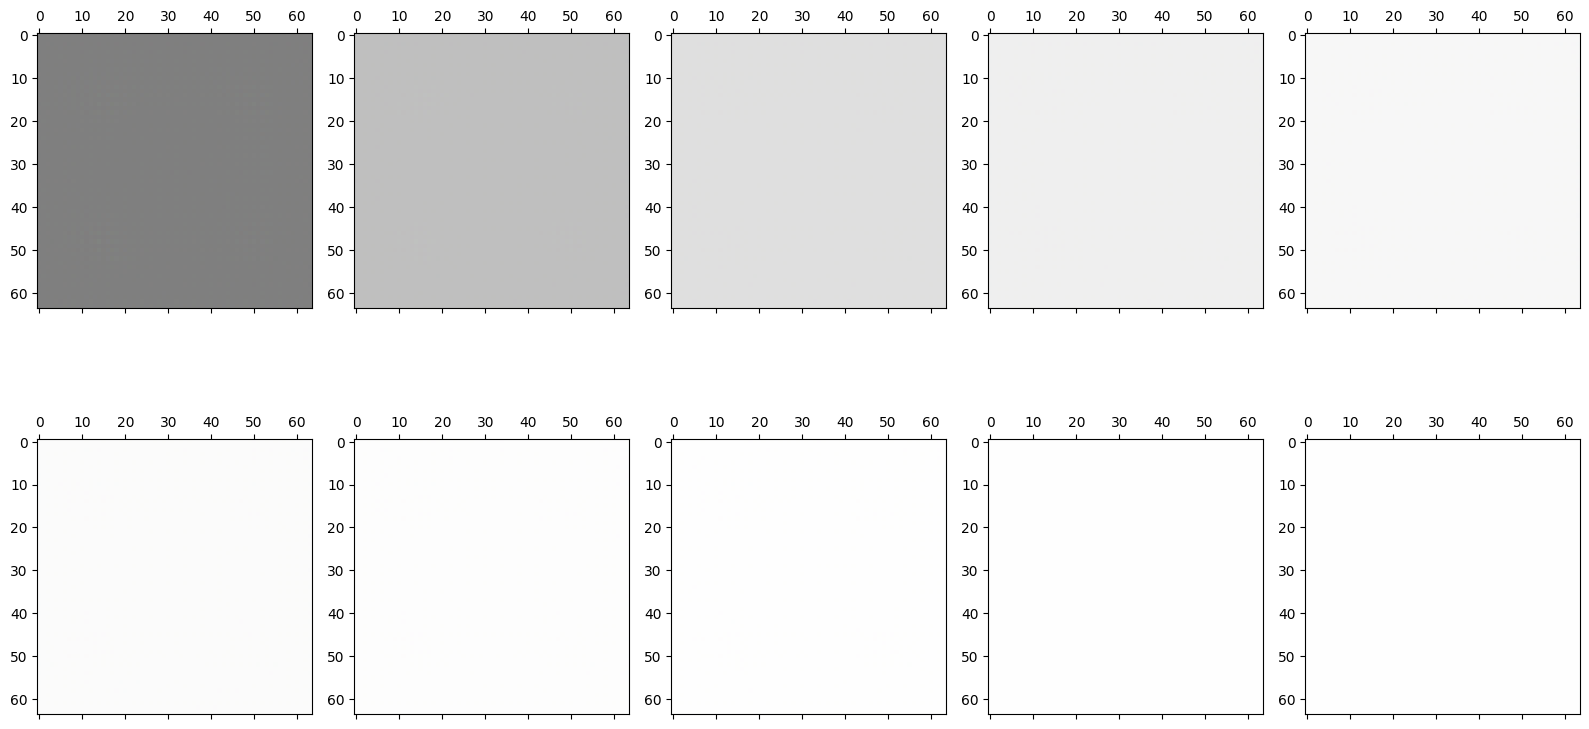

Epoch 2/1001
Epoch 3/1001
Epoch 4/1001
Epoch 5/1001
Epoch 6/1001
Epoch 7/1001
Epoch 8/1001
Epoch 9/1001
Epoch 10/1001
Epoch 11/1001
Epoch 12/1001
Epoch 13/1001
Epoch 14/1001
Epoch 15/1001


In [ ]:
# Train DCGAN model
train_gan(gan, dataset, batch_size, codings_size)

As you can see, the above function evaluates the Discriminator separately on real and fake (generated) points. Also, it shows a few model-generated images.

Note that to display fake (generated) images, we need to inverse transform the underlying data from the [-1,1] range to the [0,1] range.

Finally, the training function:

In [56]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1001, n_batch=32, n_eval=100):
    
    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)
    
    # We will manually enumare epochs 
    for i in range(n_epochs):
    
    # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch, dataset)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)
        
        # Train the discriminator using real and fake samples
        X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)
    
    # Generator training
        # Get values from the latent space to be used as inputs for the generator
        x_gan = latent_vector(latent_dim, n_batch)
        # While we are generating fake samples, 
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))
        
        # Train the generator via a composite GAN model
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)
        
        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
            performance_summary(g_model, d_model, dataset, latent_dim)

As mentioned earlier, we train the Discriminator separately by passing a batch with 50% real and 50% fake (generated) samples. Meanwhile, the Generator training happens via a combined DCGAN model.

1/1 [==============================] - 0s 139ms/step


2023-03-31 11:51:49.252362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-31 11:51:49.571272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-31 11:51:50.216875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch number:  0
*** Training ***
Discriminator Loss  0.6951806545257568
Generator Loss:  0.7729412317276001
1/2 [==============>...............] - ETA: 0s

2023-03-31 11:51:50.798740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 306ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.699999988079071
Discriminator Accuracy on FAKE (generated) images:  1.0


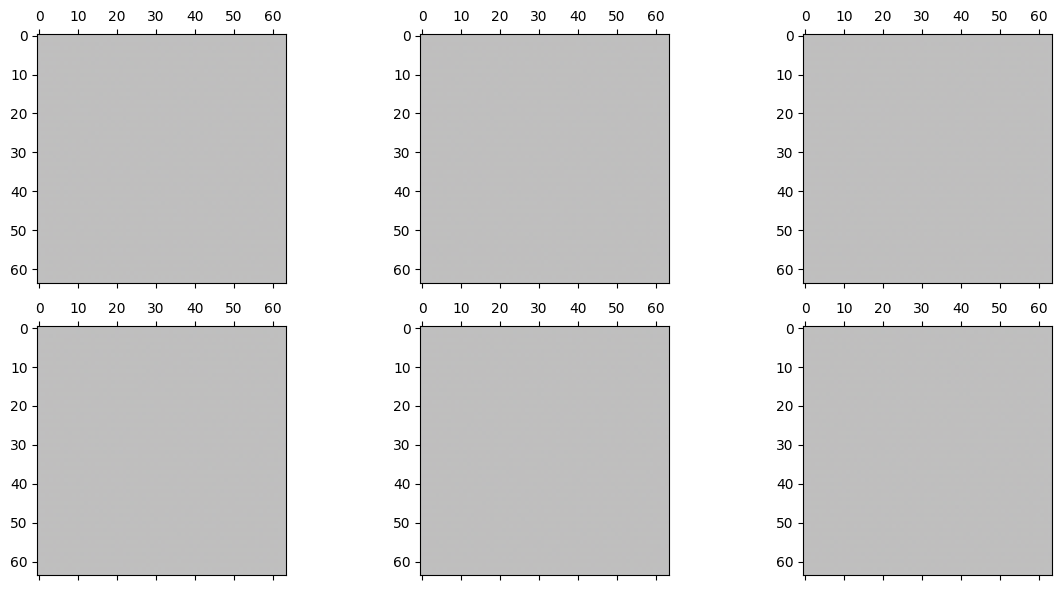

1/1 [==============================] - 0s 9ms/step
Epoch number:  100
*** Training ***
Discriminator Loss  0.0008343032095581293
Generator Loss:  6.293294906616211
2/2 [==============================] - 0s 268ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  1.0


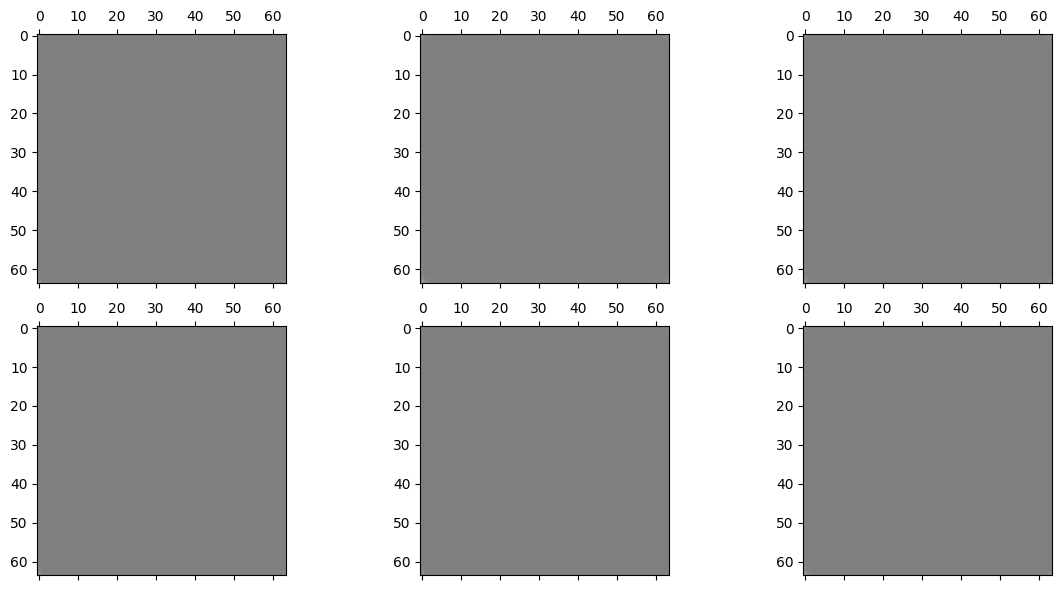

1/1 [==============================] - 0s 9ms/step
Epoch number:  200
*** Training ***
Discriminator Loss  0.09525622427463531
Generator Loss:  1.8337297439575195
2/2 [==============================] - 0s 265ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9399999976158142
Discriminator Accuracy on FAKE (generated) images:  1.0


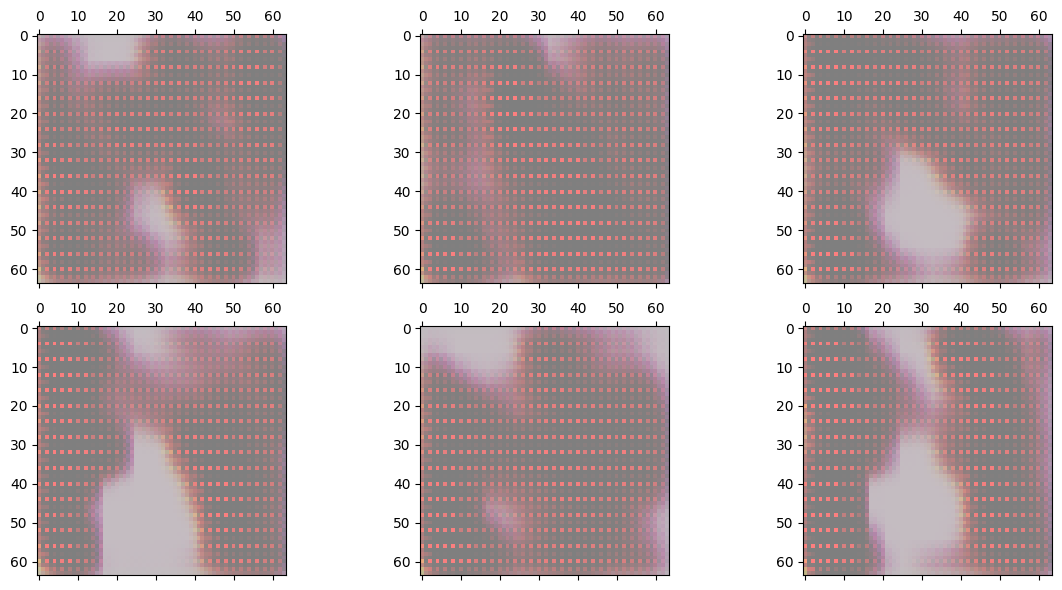

1/1 [==============================] - 0s 9ms/step
Epoch number:  300
*** Training ***
Discriminator Loss  0.0046437568962574005
Generator Loss:  2.6897192001342773
2/2 [==============================] - 0s 274ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.85999995470047
Discriminator Accuracy on FAKE (generated) images:  1.0


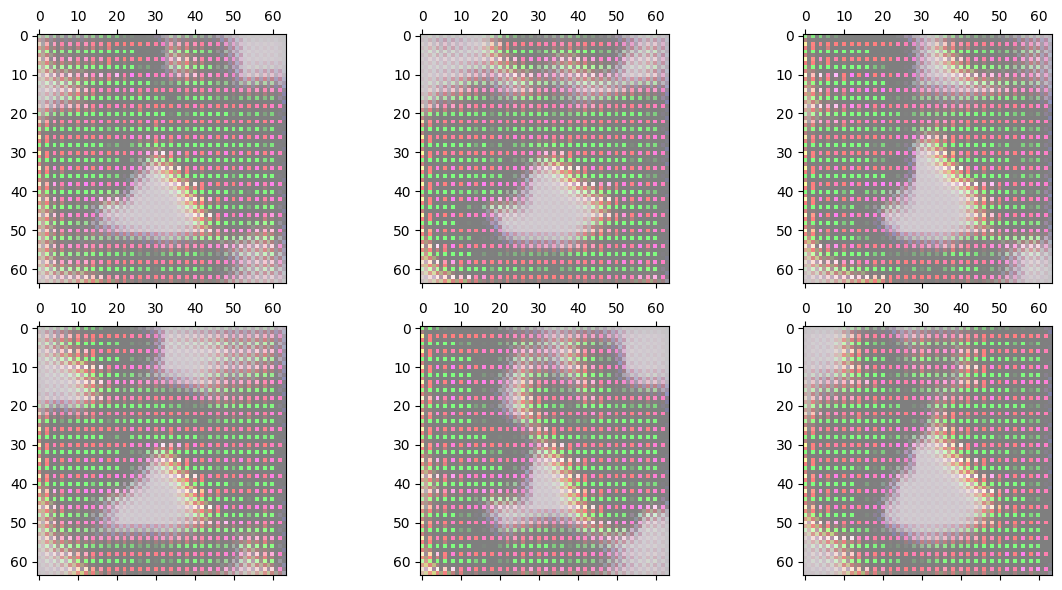

1/1 [==============================] - 0s 9ms/step
Epoch number:  400
*** Training ***
Discriminator Loss  0.0018147005466744304
Generator Loss:  3.152583122253418
2/2 [==============================] - 0s 270ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7999999523162842
Discriminator Accuracy on FAKE (generated) images:  1.0


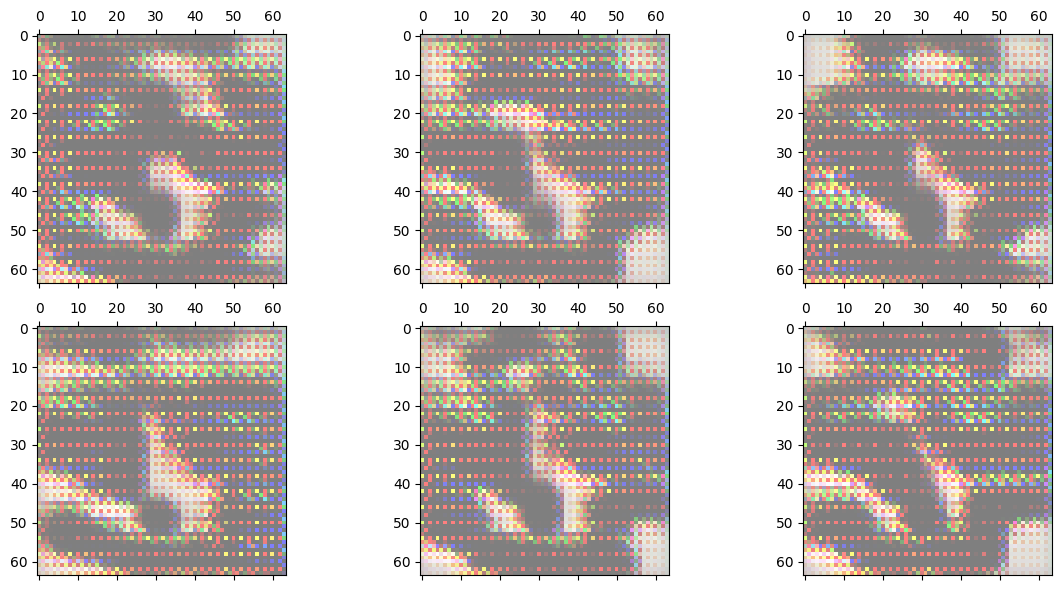

1/1 [==============================] - 0s 11ms/step
Epoch number:  500
*** Training ***
Discriminator Loss  0.0017586854519322515
Generator Loss:  3.5939810276031494
2/2 [==============================] - 0s 285ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8399999737739563
Discriminator Accuracy on FAKE (generated) images:  1.0


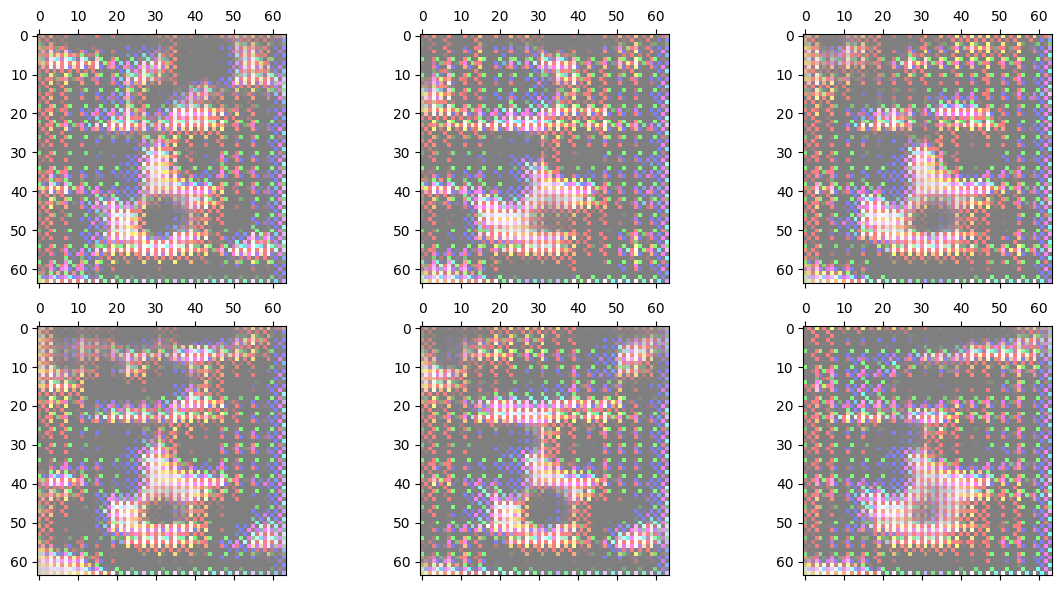

1/1 [==============================] - 0s 9ms/step
Epoch number:  600
*** Training ***
Discriminator Loss  0.001051001832820475
Generator Loss:  3.748262405395508
2/2 [==============================] - 0s 265ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7999999523162842
Discriminator Accuracy on FAKE (generated) images:  1.0


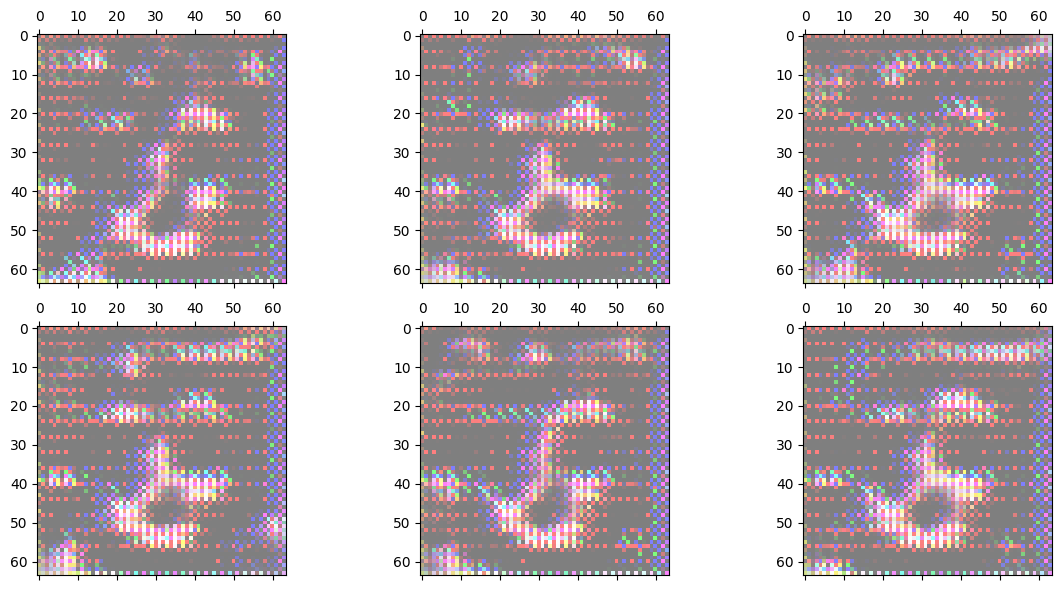

1/1 [==============================] - 0s 9ms/step
Epoch number:  700
*** Training ***
Discriminator Loss  0.0002821929519996047
Generator Loss:  3.9320192337036133
2/2 [==============================] - 0s 274ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7599999904632568
Discriminator Accuracy on FAKE (generated) images:  1.0


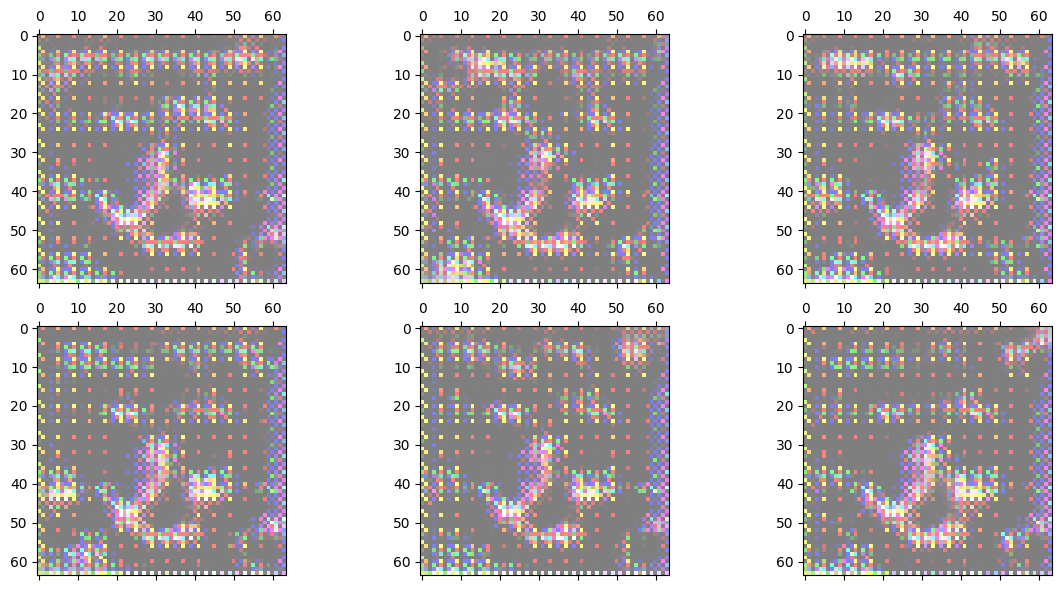

1/1 [==============================] - 0s 9ms/step


In [ ]:
# Train DCGAN model
train(gen_model, dis_model, gan_model, data, latent_dim)

As you can see, some of the images are terrible, while others look kind of artsy. However, it’s pretty clear that more training is required.